# Importación de librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

# Creación de Clusters

In [2]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Importación de dataset

Datos obtenidos de:

*The Ulabox Online Supermarket Dataset 2017, accessed from https://www.github.com/ulabox/datasets*

In [3]:
df = pd.read_csv("datasets/ulabox_orders_with_categories_partials_2017.csv")
df.describe()

,customer,order,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,5012.483367,14999.500000,31.739933,8.455495,3.642367,15.034667,23.560406,20.227279,23.349235,13.539575,5.892949,1.132959,11.096145,1.043087
std,2888.646245,8660.398374,20.576579,14.199350,2.122031,5.717052,21.719824,23.661767,22.523335,17.850282,13.996518,5.307620,24.740364,6.195390
min,0.000000,0.000000,1.000000,-65.150000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2541.750000,7499.750000,18.000000,1.177500,2.000000,11.000000,7.220000,0.000000,6.710000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5043.000000,14999.500000,29.000000,4.160000,3.000000,15.000000,19.650000,10.930000,17.890000,7.210000,0.000000,0.000000,0.000000,0.000000
75%,7483.000000,22499.250000,41.000000,9.990000,5.000000,20.000000,33.260000,35.790000,33.162500,20.002500,6.512500,0.000000,4.172500,0.000000
max,10238.000000,29999.000000,298.000000,100.000000,7.000000,23.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


# Preguntas

### **Pregunta1:** _Relación total_items y discount%_

> **Hipotesis:**
A mayor número de productos seleccionados en una compra, mayor será el porcentaje de descuento aplicado al total de la compra.

Para saber si existe o no existe una relación entre ambas variables, se empezará con un análisis general de sus comportamientos, para esto se realizará un **Diagrama de dispersión** donde:
- el **_eje x_** represente el **_número total de productos_**
- el **_eje y_** represente el **_porcentaje de descuento_** aplicado a la compra.

<AxesSubplot:xlabel='total_items', ylabel='discount%'>

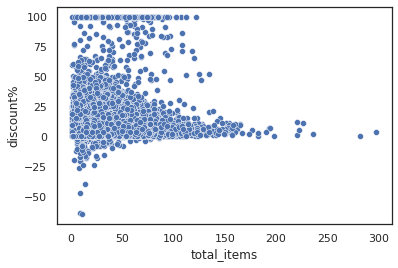

In [4]:
sns.scatterplot(data=df, x="total_items", y="discount%")

No se aprecia que la hipotesis se cumpla, pues existe una **gran amplitud en los rangos** de descuento e incluso en los casos con mayor número de items _(a partir de 200)_ los descuentos son pequeños.

Para indagar más y dar nuestra hipotesis por equivocada, realizaremos un **Mapa de calor** que nos muestre la correlación existente entre estas 2 variables, **de ser menor a 0.5** podemos concluir que no tienen relación.

<AxesSubplot:>

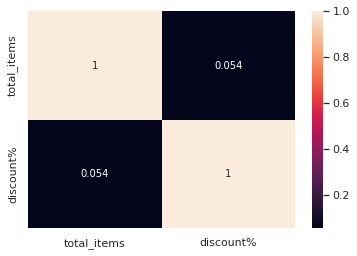

In [5]:
test1 = df.iloc[:,[2,3]]
sns.heatmap(test1.corr(), annot=True)

Como es evidente, al tener una **correlación menor a 0.1**, se puede concluir que no existe una relación directa entre el número de productos comprados y el descuento que se aplica en la compra y que por ende:

**es incorrecto decir que una gran compra te asegura un gran descuento.**

### Pregunta 2: El momento de la semana ideal

> **Necesidad:**
Se desea encontrar el día y la hora en el que **hay un mayor número de _artículos vendidos_** en la semana, esto para aumentar la productividad del personal, así mismo, se necesita saber el día en el que **hay un menor número** de productos vendidos para dar cabida al mantenimiento de las instalaciones e innovación.

Para lograr esto, se categorizarán la variable **_total_items_** para encontrar los día en los que se vende por encima y por debajo del promedio anual.

In [29]:
ventas_fuertes = df['total_items'].mean() // 1
max_ventas = df['total_items'].max()
print("El promedio anual de número de productos por compra es:", ventas_fuertes)
df['compra_cat'] = pd.cut(df.total_items, [0,ventas_fuertes,max_ventas],
labels=['por debajo', 'por encima'])

El promedio anual de número de productos por compra es: 31.0


Como un primer acercamiento, se evaluará con un gráfico de barras si se venden mas productos por encima y por debajo de la media **entre semana y los fines de semana**.

<AxesSubplot:xlabel='day_cat', ylabel='count'>

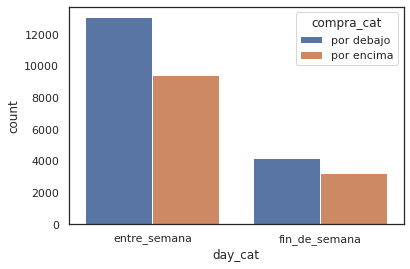

In [32]:
df['day_cat'] = pd.cut(df.weekday, [0,5,7], labels=['entre_semana', 'fin_de_semana'])
sns.countplot(data=df, x="day_cat", hue='compra_cat')

Da la clara impresión de que **entre semana se procesan más compras** _(tanto por debajo como por encima del promedio)_, sin embargo, esto es lógico simplemente por el hecho de que entre semana hay 5 días y en fin de semana solo hay 2.

Para evitar caer en sesgos, se profundizará más en el tema a través de un estudio de **los días específicos** en los que se venden más productos

<AxesSubplot:xlabel='weekday', ylabel='count'>

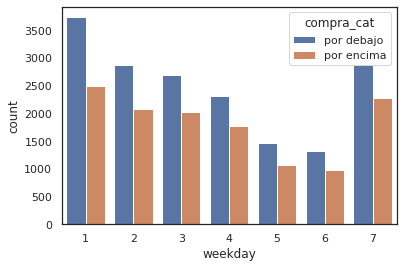

In [34]:
sns.countplot(data=df, x="weekday", hue='compra_cat')

Se puede apreciar como el día en el que se vende más productos (con mayor demanda de personal) **es el lunes**, mientras que en el que se vende menos (propicio para mantenimiento) **es el sábado**

Para averiguar las horas ideales para ambos propósitos, será **necesario crear dos nuevos** datasets que se estudiarán mediante un gráfico de barras.

In [25]:
dias_fuertes = df[(df['weekday'] == 1) & (df['compra_cat'] == 'por encima')]
dias_debiles = df[(df['weekday'] == 6) & (df['compra_cat'] == 'por debajo')]

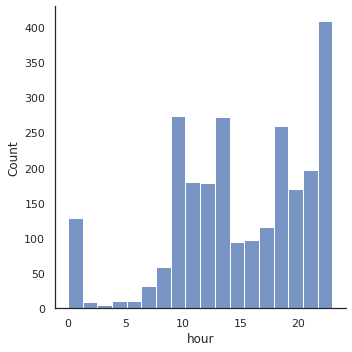

In [26]:
sns.displot(data=dias_fuertes, x='hour')

Se puede concluir que el momento ideal para **aumentar la productividad del personal** son los **Lunes a partir de las 21:00.**

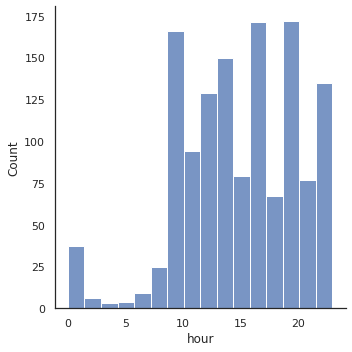

In [28]:
sns.displot(data=dias_debiles, x='hour')

Se puede concluir que el momento ideal para **aumentar dar mantenimiento a las instalaciones** son los **Sábados a las 5 de la mañana.**